# Установка и импорт необходимых библиотек

In [148]:
!pip install wordcloud

In [1]:
!pip install --proxy 10.0.0.1:3128 nltk gensim pandas pymorphy2 emoji numpy

Using legacy 'setup.py install' for docopt, since package 'wheel' is not installed.
    Running setup.py install for docopt: started
    Running setup.py install for docopt: finished with status 'done'


You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [94]:
!pip install --proxy 10.0.0.1:3128 matplotlib

ERROR: Could not find a version that satisfies the requirement matplotlib (from versions: none)
ERROR: No matching distribution found for matplotlib
You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from gensim.models import Word2Vec as wv
from gensim.models import KeyedVectors
import pymorphy2
from pymorphy2 import MorphAnalyzer
import emoji
import zipfile
import numpy as np
from pymongo import MongoClient
import json
from collections import Counter
import matplotlib.pyplot as plt
import datetime
import time
from wordcloud import WordCloud

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


True

In [8]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Максим\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Загрузка датасета из mongo db

In [9]:
def get_db_connection(db_server, db_name, collection_name):
    client = MongoClient(db_server, 27017)
    db = client[db_name]
    connection = db[collection_name]
    return connection

In [10]:
connector = get_db_connection('localhost', 'parcer', 'posts')

In [11]:
res = list(connector.find())

In [12]:
mongo_data = list()

In [13]:
for doc in res:
    mongo_data.append(doc['text'])

In [14]:
mongo_ds = pd.Series(mongo_data, copy=False, dtype=object)

In [15]:
mongo_ds

0      ⚠️ Первый случай присасывания клеща зарегистри...
1      📢День рождения У нас, а подарочки для Вас! \n💥...
2      ⚠️ В Барнауле в тестовом режиме начал свою раб...
3      ⚠️ Объём федеральной поддержки для аграриев ув...
4                          🆘 В Барнауле пропал подросток
                             ...                        
178    🇷🇺Недавно мы передали швейбатам флис и замки д...
179    ❗️[club173382369|Леонид Слуцкий]: в России нуж...
180    ❗️В Государственной Думе открылась фотовыставк...
181    ❄️Снег растаял - асфальт вместе с ним \n\nЛДПР...
182    💛У нас для вас отличные новости! \n\nС апреля ...
Length: 183, dtype: object

In [16]:
posts_count = mongo_ds.count()

In [17]:
mongo_comments = list()

In [18]:
for doc in res:
    for comment in doc['comments']:
        mongo_comments.append(comment['text'])

In [19]:
comments_ds = pd.Series(mongo_comments, copy=False, dtype=object)

In [20]:
comments_ds

0                                                        
1       Очень хорошая автошкола! Получали с мужем прав...
2       Офигеть. Я уже подумал что в тестовом режиме е...
3                 А дальше куда? Там же нет разворотника🤔
4                            А, что его до этого не было?
                              ...                        
3323            Давно пора!  Особенно в нынешних реалиях!
3324                                  Полностью согласна👍
3325                                                 Пора
3326    Даже Слуцкий заговорил о мерах наказания, а на...
3327                                                 🙏🙏🙏🙏
Length: 3328, dtype: object

In [21]:
comments_count = comments_ds.count()

In [22]:
all_data = pd.concat([comments_ds, mongo_ds], ignore_index=True)

In [23]:
reserved_data = pd.concat([comments_ds, mongo_ds], ignore_index=True)

In [24]:
all_data

0                                                        
1       Очень хорошая автошкола! Получали с мужем прав...
2       Офигеть. Я уже подумал что в тестовом режиме е...
3                 А дальше куда? Там же нет разворотника🤔
4                            А, что его до этого не было?
                              ...                        
3506    🇷🇺Недавно мы передали швейбатам флис и замки д...
3507    ❗️[club173382369|Леонид Слуцкий]: в России нуж...
3508    ❗️В Государственной Думе открылась фотовыставк...
3509    ❄️Снег растаял - асфальт вместе с ним \n\nЛДПР...
3510    💛У нас для вас отличные новости! \n\nС апреля ...
Length: 3511, dtype: object

In [25]:
comments_avg = comments_count/posts_count

In [26]:
comments_rounded = round(comments_avg, 1)

In [27]:
comments_rounded 

18.2

# Предобработка сообщений социальной сети

In [28]:
all_data = reserved_data

In [29]:
flags = ['🇷🇺',]

def divide_emoji(doc):
    for c in str(doc):
        if emoji.is_emoji(c):
            i = doc.index(c)
            doc = re.sub(doc[i], ' ' + doc[i] + ' ', str(doc))
        elif c in flags:
            print(c)
            i = doc.index(c)
            doc = re.sub(doc[i], ' ' + doc[i] + ' ', str(doc))
    return doc

In [30]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

def lemmatize(doc):
    tokens = []
    doc = re.sub(patterns, ' ', str(doc))
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    return tokens

In [31]:
pattern = r'\[(.*?)\]'

def reply_delete(doc):
    doc = re.sub(pattern, ' ', str(doc))
    return doc

In [32]:
all_data = all_data.dropna()

In [33]:
all_data = all_data.apply(divide_emoji)

In [34]:
all_data = all_data.apply(reply_delete)

In [35]:
all_data = all_data.apply(lemmatize)

In [36]:
cloud_data = pd.DataFrame()

In [37]:
cloud_data['text'] = all_data

In [38]:
text = ''

In [39]:
text_listed = []

In [40]:
for row in cloud_data['text']:
    for word in row:
        text = text + ' ' + word

In [41]:
for row in cloud_data['text']:
    for word in row:
        text_listed.append(word)

In [42]:
text_listed

['очень',
 'хороший',
 'автошкола',
 'получать',
 'муж',
 'право',
 'год',
 'муж',
 'сдать',
 'первый',
 'раз',
 'второй',
 'цена',
 'вообще',
 'хороший',
 'офигеть',
 'я',
 'подумать',
 'тестовый',
 'режим',
 'ехать',
 'власих',
 'вон',
 'оно',
 'что',
 'а',
 'далёкий',
 'там',
 'разворотник',
 '🤔',
 'а',
 'этот',
 'мера',
 'позволить',
 'просубсидировать',
 'вдвое',
 'больший',
 'объём',
 'урожай',
 'тысяча',
 'тонна',
 'зерно',
 'но',
 'булка',
 'хлеб',
 'магазин',
 'копейка',
 'дешёвый',
 'увы',
 'стать',
 'сельхозпроизводитель',
 'понимать',
 'почему',
 'пшеница',
 'дешеветь',
 'хлеб',
 'магазин',
 'пшеница',
 'дорожать',
 'хлеб',
 'соответственно',
 'как',
 'бензин',
 'нефть',
 'прям',
 'точно',
 'апрель',
 'это',
 'сегодня',
 'час',
 'ещё',
 'ранний',
 'начать',
 'искать',
 'последний',
 'время',
 'ребёнок',
 'стать',
 'пропадать',
 'частый',
 'находить',
 'мёртвый',
 'пропадать',
 'умирать',
 'частый',
 'стать',
 'весна',
 'наносить',
 'свой',
 'отпечаток',
 'стать',
 'просто',

In [43]:
text

' очень хороший автошкола получать муж право год муж сдать первый раз второй цена вообще хороший офигеть я подумать тестовый режим ехать власих вон оно что а далёкий там разворотник 🤔 а этот мера позволить просубсидировать вдвое больший объём урожай тысяча тонна зерно но булка хлеб магазин копейка дешёвый увы стать сельхозпроизводитель понимать почему пшеница дешеветь хлеб магазин пшеница дорожать хлеб соответственно как бензин нефть прям точно апрель это сегодня час ещё ранний начать искать последний время ребёнок стать пропадать частый находить мёртвый пропадать умирать частый стать весна наносить свой отпечаток стать просто публиковать информация ваш сутки ждать нет такой норма бред киношный чем ранний выяснить ь пропажа шанс положительный результат и надо день ждать твой кто разговаривать 🤔 весёлый макс не нажать кнопка ответить видимо день ждать хотя утро просто год человек паспорт ладный почему последний лицо похожий какой чёрт страна летний дом выбрасываться что часто стать проп

In [44]:
text_counter = Counter(text_listed)

In [45]:
text_counter.most_common(300)

[('это', 534),
 ('🤣', 280),
 ('а', 241),
 ('год', 239),
 ('такой', 229),
 ('человек', 217),
 ('в', 215),
 ('ребёнок', 203),
 ('который', 192),
 ('️', 182),
 ('свой', 147),
 ('дом', 142),
 ('всё', 140),
 ('быть', 136),
 ('ещё', 131),
 ('😂', 124),
 ('барнаул', 123),
 ('и', 122),
 ('весь', 116),
 ('на', 109),
 ('мочь', 106),
 ('\u200d', 102),
 ('город', 99),
 ('я', 98),
 ('просто', 98),
 ('день', 97),
 ('кто', 97),
 ('так', 95),
 ('👍', 94),
 ('новый', 94),
 ('сам', 93),
 ('один', 89),
 ('наш', 88),
 ('какой', 87),
 ('знать', 87),
 ('тот', 84),
 ('место', 84),
 ('писать', 84),
 ('деньга', 83),
 ('должный', 82),
 ('рубль', 82),
 ('собака', 81),
 ('другой', 79),
 ('мы', 78),
 ('не', 77),
 ('работать', 77),
 ('хороший', 76),
 ('первый', 76),
 ('этот', 74),
 ('сказать', 74),
 ('сделать', 74),
 ('вы', 74),
 ('край', 74),
 ('хотеть', 73),
 ('©', 73),
 ('говорить', 72),
 ('что', 71),
 ('♂', 71),
 ('время', 70),
 ('дорога', 70),
 ('делать', 70),
 ('нужно', 69),
 ('врач', 69),
 ('случай', 67),
 ('д

In [46]:
test_text = 'a lot of emojis 😂😂😂😂🤯🤯🤯🚀🚀🚀🍷🍷🍷🍷🍷💡💡😅'

In [ ]:
wc = WordCloud(font_path='./Symbola.otf',
                               width=2000,
                               height=1000,
                               background_color='white',
                               random_state=42,
                               collocations=False).generate(test_text)

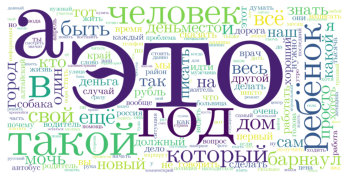

In [152]:
plt.imshow(wc)
plt.axis("off")
plt.show()

# Статистика использования СГИ в сообщениях соц сети 

In [73]:
total = all_data.count()

In [74]:
total

1524

In [75]:
def split(s):
    return [char for char in s]


def check(comment):
    flag=0
    for item in comment:
        for c in split(item):
            if emoji.is_emoji(c):
                flag+=1
    if flag > 0:
        return(comment)
    return None 

In [76]:
all_data = all_data.apply(check)

In [77]:
all_data = all_data.dropna()

In [78]:
all_data

4       [какой, красота😁, и, хотеть, засыпать, нужно, ...
6       [антон, приложить, усилие, улучшение, кошка, д...
9       [перепутать, газ, тормозом😂, трезвый, ездить, ...
10      [владислав, ещё, выступать, начать, судить, фо...
13      [жек, красавчик, борцуха, 😂☝️, когда, суета, н...
                              ...                        
1519    [как, отдохнуть, дешёвый, 🤔⠀, ⠀⠀, подписаться,...
1520    [⚠️, спасение, четыре, брат, и, вновь, спасате...
1521    [🙏, пост, благодарность, хотеть, выразить, огр...
1522    [🌿, весна, основательно, прийти, заповедный, б...
1523             [☀️добрый, утро, барнаул, сегодня, день]
Length: 332, dtype: object

In [79]:
all_data.count()

332

In [80]:
all_data.count()/total

0.2178477690288714

# График по количеству публикаций в день 

In [83]:
res[0]

{'_id': ObjectId('64268222eddd3948046724a5'),
 'public': 'https://vk.com/barneos22',
 'id': 7339263,
 'date': '28/03/2023',
 'text': '🌙Спокойной ночи, Барнаул!😴\n\nФото:  onetones',
 'comments': [{'user': 304160659, 'text': 'Дубай?'},
  {'user': 174754608, 'text': '[id304160659|Боб], Барнаулай.'},
  {'user': 87386708, 'text': 'Это Ковш??? Его хотят засыпать???'},
  {'user': 38382358, 'text': '[id87386708|Елена], да'},
  {'user': 398907352,
   'text': 'Какая красота😁\nИ еще хотят его засыпать, его нужно облагородить и дать людям возможность отдыхать, как было запланировано по проекту, набережная с стоянкой маломерных судов.'},
  {'user': 134867674,
   'text': '[id398907352|Владимир], а пока там дохлые кошки валяются. Отличное место для прогулок.'},
  {'user': 398907352,
   'text': '[id134867674|Антон], так приложить усилия для улучшения, а кошки дохлые, после зимы много где оттаят😉'},
  {'user': 486034143, 'text': 'Когда сделано фото ?'},
  {'user': 20826319,
   'text': 'да просто верну

In [87]:
date_counter = list()

In [113]:
for doc in res:
    date_stamp = int(datetime.datetime.strptime(doc['date'], "%d/%m/%Y").timestamp())
    date_counter.append(date_stamp)

In [114]:
cnt = Counter(date_counter)

In [116]:
cnt

Counter({1679950800: 30, 1680123600: 68, 1680037200: 76})

In [121]:
counter_dict = dict(cnt)

In [124]:
counter_dict 

{1679950800: 30, 1680123600: 68, 1680037200: 76}

In [122]:
sorted_dict = sorted(counter_dict)

In [123]:
plot_dict = {}

In [147]:
for k in sorted_dict:
    print(k)
    stmp_date = time.gmtime(k + 86400)
    readable = time.strftime("%d.%m.%Y", stmp_date)
    plot_dict[readable] = counter_dict[k]

1679950800
1680037200
1680123600


In [148]:
plot_dict

{'28.03.2023': 30, '29.03.2023': 76, '30.03.2023': 68}

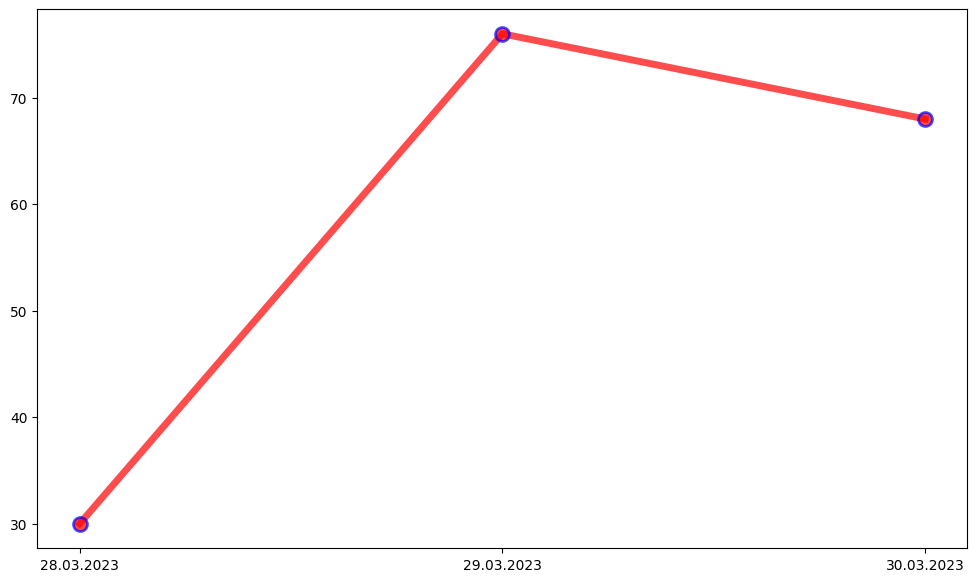

In [149]:
x = plot_dict.keys()
y = plot_dict.values()

plt.figure(figsize=(12, 7))
plt.plot(x, y, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)